# Map AGB on ATL08; show as boreal polar map  
Paul Montesano, March 2023  

#conda activate r-with-gdal  

`mamba install -c conda-forge r-rnaturalearth r-rnaturalearthdata r-mapproj r-rgeos r-viridis r-wesanderson r-patchwork r-aws.s3 r-feather r-rockchalk`

In [3]:
#library(aws.s3)
library(rgdal)
library(raster)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(data.table)

library(fs)
library(sf)
library(rgdal)


#library(rgeos)
#library(mapproj)
#library(rgee)
library(viridis)
#library(wesanderson)
library(scales)
library(tools)
library(patchwork)

library(rnaturalearth)
library(rnaturalearthdata)
#library(feather)
library(tools)
library(rockchalk)

Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-32, (SVN revision 1176)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.6.2, released 2023/01/02
Path to GDAL shared files: /opt/conda/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 9.1.0, September 1st, 2022, [PJ_VERSION: 910]
Path to PROJ shared files: /projects/.local/share/proj:/opt/conda/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.5-1
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ g

### Read in ATL08 AGB file

In [5]:
atl08_fn = '/projects/my-public-bucket/boreal_ATL08_AGB/tables/atl08_agb_boreal_clip_circumboreal_20231122.gpkg'
atl08 = st_read(atl08_fn)

Reading layer `atl08_agb_boreal_clip_circumboreal_20231122' from data source 
  `/projects/my-public-bucket/boreal_ATL08_AGB/tables/atl08_agb_boreal_clip_circumboreal_20231122.gpkg' 
  using driver `GPKG'
Simple feature collection with 19287550 features and 18 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -164.3112 ymin: 44.4398 xmax: 169.1362 ymax: 71.41131
CRS:           unknown


## Set output figure dir.

In [6]:
OUT_FIGURE_DIR = '/projects/my-public-bucket/boreal_ATL08_AGB/paper_figs'

In [7]:
# Circ map new: trying to combine the best of the sf and sp approaches
DO_MAP_BOREAL_SP <- function( MAP_EXTENT = extent(-180,180,45,90), xlim=NULL, ylim=NULL, rotate_map=0, proj_name = 'azequalarea', LAYER_LIST=NULL, 
                             boreal_shp_fn = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'){
  #
  # Map with a polar projection
  #
  
  # Color scale help
  #https://biostats.w.uib.no/color-scale-for-continuous-variables/
  
  #source(path("C:\\Users\\pmontesa\\Google Drive\\Work\\R","plot_functions.R"))
  # Shapefiles
  
  world <- crop(ne_countries(scale = "medium", returnclass = "sp"), MAP_EXTENT)
  
  # WWF
  #boreal <- shp_fort_join("D:\\databank\\wwf\\arc\\wwf_circumboreal_Dissolve.shp", MAP_EXTENT, REPROJECT = TRUE)
  # TerraPulse
  boreal <- shp_fort_join(boreal_shp_fn, MAP_EXTENT, REPROJECT = TRUE)
  
  map_list_base = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill="grey90", color=NA),
    geom_polygon(data = boreal, aes(x = long, y = lat, group = group), color=NA, fill="grey70"))
    
  map_list_top = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill=NA, color="black", size=0.1 ),
    
    theme_minimal() , 
    theme(axis.text = element_blank(), axis.title = element_blank() ) ,
    
    #geom_polygon(data = fortify(continents.df_stereo), aes(x = long, y = lat, group = group), fill = NULL, colour = "black", size=0.25) +
    #scale_color_distiller(palette = "Greens", direction = 1, name = "%"),
    #scale_color_manual(values = COLOR_PAL, name = map_str) ,
    guides(guide = guide_legend(direction = "horizontal", nrow=1, label.position = "bottom", title.position = "bottom") ) ,
    theme(legend.position="top",
          legend.title = element_text(size=9),
          #       legend.direction  = 'vertical',
          legend.key.width  = unit(1.0, "cm"),
          legend.key.height = unit(.25, "cm")  )
  )
  
  if(is.null(LAYER_LIST)){
    map_list = list(
      map_list_base,
      map_list_top
    )
  }else{
    map_list = list(
      map_list_base,
      LAYER_LIST,
      map_list_top
    )
  }
  
  p_map = ggplot() + map_list +
    #coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map, xlim = xlim, ylim = ylim)
    coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map)
  
  if(FALSE){
    out_plot_fn = paste0("D:/projects/3dsi/plots/map_boreal_",proj_name,"_", format(Sys.time(), "_%Y%m%d"),'.png')
    print(out_plot_fn)
    ggsave(plot = p_map ,
           file = out_plot_fn,
           device = 'png', dpi = 300, width = 5, height = 5)
  }
  #print(p_map)
  return(p_map)
  
}

coord_map_stereo_list <- function(proj_name = "stereo", rotation = 0, min_lat = 50, xlims=NULL, ylims=NULL, LABEL_SIZE=3){ 
  
  # Defines the x axes required
  lat_lines = seq(min_lat+10, 80, by = 10)
  lat_labs = paste0(seq(min_lat+10, 80, by = 10), "\u00B0N")
  
  lon_lines = seq(0, 330, by = 30)
  lon_labs = c("0", paste0(seq(30, 150, by = 30), "°E"), "180", rev(paste0(seq(30, 150, by = 30), "°W")))
  
  
  return(list(
    # Convert to polar coordinates
    coord_map(proj_name, orientation = c(90, 0, rotation, xlims=xlims, ylims=ylims)), #"ortho""
    scale_y_continuous(breaks = seq(45, 90, by = 5), labels = NULL),
    
    # Removes Axes and labels
    scale_x_continuous(breaks = NULL),
    xlab(""),
    ylab(""),
    
    # Adds axes
    # Latitude
    geom_hline(aes(yintercept = lat_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    # Outer circular border
    geom_hline(aes(yintercept = min_lat), size = 0.25), #1
    # Longitude
    geom_vline(aes(xintercept = lon_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    #geom_segment(aes(y = 45, yend = 85, x = x_lines, xend = x_lines), linetype = "dotted") +
    
    # Adds labels
    #geom_text(aes(x = 0, y = lat_lines, hjust = 0.5, label = lat_labs)),
    geom_label(aes(x = 0, y = lat_lines, label = lat_labs), label.size = NA, size=LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),
    #geom_text(aes(x = lon_lines, y = min_lat-3, hjust = 0.5, vjust = 0.5, label = lon_labs), size = 2.5), #hjust = 0.5
    # min-3 so lon labels are centered over outer line
    geom_label(aes(x = lon_lines, y = min_lat-3, label = lon_labs), label.size = NA,  hjust='inward', vjust='inward', size = LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),  #y = min_lat-3 why used to be this?
    
    ##guides(fill=FALSE)+
    
    # Change theme to remove axes and ticks
    theme(panel.background = element_blank(),
          #panel.grid = element_line(size = 0.25, linetype = 'dotted', colour = "grey50"),
          axis.ticks=element_blank())
    #,
    #labs(caption = "Source: circ_tte_map.Rmd")
  ))
}  
shp_fort_join = function(shapefile_fn, ext, REPROJECT=FALSE){

  shp_name = tools::file_path_sans_ext(basename(shapefile_fn))
  shp = readOGR(shapefile_fn, layer = shp_name)
  # Test this, so you can read in geojson and gpkg
  #shp = sf::st_read(shapefile_fn)

  if(REPROJECT){
      # Shapefile reprojection to geog
      geog_proj4 = '+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0'
      shp <- spTransform(shp, geog_proj4)
  }

  shp <- crop(shp, ext)
  
  #Get attributes, fortify data, and merge attributes to data
  tbl = shp@data
  tbl$id <- rownames(tbl)
  shp.df <- ggplot2::fortify(shp, id = "id")
  
  return(plyr::join(shp.df, tbl, by = "id"))
}

gridCreate<-function(shp, res,proj_out, buffer=10000){
  
  if (!is.null(buffer)){
    shp<-buffer(shp, width=buffer)
  }
  ext <- floor(extent(shp))
  rr <- raster(ext, res=res)
  rr <- rasterize(shp, rr, field=1)
  rr[!is.na(rr[])]<-1:length(rr[!is.na(rr[])])
  grid<-rasterToPolygons(rr)
  crs(grid)<-projection(shp)
  if (!proj_out==projection(shp)){
    grid<-spTransform(grid,CRS(proj_out))
  }
  return(grid)  
}

crs_canalb = "+proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
crs_albers = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=180 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
crs_gcs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

In [8]:
# Final file
AGB_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.csv"

# Final file
ATL08_filt_tindex_master_fn = "s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv"

In [9]:
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 

# Read the tindex from s3
AGB_tindex_master <- aws.s3::s3read_using(read.csv, object = AGB_tindex_master_fn)

In [10]:
boreal_shp_fn = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'
boreal_shp_fn = '/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson'
boreal = st_read(boreal_shp_fn)
boreal_albers<-spTransform(sf:::as_Spatial(boreal),CRS(crs_albers))

Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -164.95 ymin: 44.39544 xmax: 169.9216 ymax: 71.41746
Geodetic CRS:  WGS 84


In [11]:
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
crs_wgs84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
boreal_tiles_clip = st_intersection(
                                st_read(boreal_tile_index_path) %>% st_transform(crs=crs_wgs84), 
                                boreal)#%>% as.data.frame()
boreal_tiles_clip_NA = st_intersection(
                                st_read(boreal_tile_index_path) %>% st_transform(crs=crs_wgs84), 
                                boreal %>% filter(REALM == 'NA') )
boreal_tiles_clip_PA = st_intersection(
                                st_read(boreal_tile_index_path) %>% st_transform(crs=crs_wgs84), 
                                boreal %>% filter(REALM == 'PA') )

Reading layer `boreal_tiles_v003' from data source 
  `/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
  using driver `GPKG'
Simple feature collection with 5337 features and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -6111478 ymin: 1233304 xmax: 6308522 ymax: 10323300
Projected CRS: unnamed


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Reading layer `boreal_tiles_v003' from data source 
  `/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
  using driver `GPKG'
Simple feature collection with 5337 features and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -6111478 ymin: 1233304 xmax: 6308522 ymax: 10323300
Projected CRS: unnamed


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Reading layer `boreal_tiles_v003' from data source 
  `/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
  using driver `GPKG'
Simple feature collection with 5337 features and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -6111478 ymin: 1233304 xmax: 6308522 ymax: 10323300
Projected CRS: unnamed


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


#### Get only the boreal tile nums that coincide with the boreal extent

In [12]:
boreal_tile_num_list = boreal_tiles_clip %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list = unlist(boreal_tile_num_list[[1]])
length(boreal_tile_num_list)

[1] 3015

In [13]:
boreal_tile_num_list = boreal_tiles_clip %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list = unlist(boreal_tile_num_list[[1]])
length(boreal_tile_num_list)

[1] 3015

In [14]:
boreal_tile_num_list_NA = boreal_tiles_clip_NA %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list_NA = unlist(boreal_tile_num_list_NA[[1]])
length(boreal_tile_num_list_NA)

[1] 1032

In [15]:
boreal_tile_num_list_PA = boreal_tiles_clip_PA %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list_PA = unlist(boreal_tile_num_list_PA[[1]])
length(boreal_tile_num_list_PA)

[1] 1983

In [16]:
ext = extent(-180,180,40,90)

In [17]:
boreal_tiles_gcs = shp_fort_join(boreal_tile_index_path, ext, REPROJECT=TRUE)

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum unknown in Proj4 definition: +proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs,
 but +towgs84= values preserved”


OGR data source with driver: GPKG 
Source: "/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg", layer: "boreal_tiles_v003"
with 5337 features
It has 4 fields
Integer64 fields read as strings:  tile_num 


Warning message:
“`fortify(<SpatialPolygonsDataFrame>)` was deprecated in ggplot2 3.4.4.
ℹ Please migrate to sf.”
Regions defined for each Polygons


# ICESat-2 ATL08 30m obs

### Map n obs per tile

In [18]:
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 
# # SPRING 2022 version
# ATL08_filt = read.csv("/projects/shared-buckets/nathanmthomas/DPS_tile_lists/07/ATL08_filt_tindex_master.csv")
# # FALL 2022 version using atl03 rh metrics (does not include ground photons in calc of RH metrics)
# Atl08_filt = read.csv("/projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv")

# FALL 2022 version used for final map
#Atl08_filt = read.csv("/projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/ATL08_filt_tindex_master.csv")
# Read the tindex from s3
Atl08_filt <- aws.s3::s3read_using(read.csv, object = ATL08_filt_tindex_master_fn)

boreal_tiles_gcs_ATL08obs = boreal_tiles_gcs %>% 
    dplyr::mutate(tile_num = as.numeric(tile_num)) %>% 
    dplyr::left_join(Atl08_filt, by = c('tile_num' = 'tile_num'))
head(boreal_tiles_gcs_ATL08obs)

long     lat      order hole  piece id group tile_num tile_version
1 4.624619 56.64562 1     FALSE 1     1  1.1   1        version 1   
2 5.390977 57.33162 2     FALSE 1     1  1.1   1        version 1   
3 6.672362 56.91323 3     FALSE 1     1  1.1   1        version 1   
4 5.890771 56.23471 4     FALSE 1     1  1.1   1        version 1   
5 4.624619 56.64562 5     FALSE 1     1  1.1   1        version 1   
6 3.329813 57.04317 1     FALSE 1     2  2.1   2        version 1   
  tile_group   map_version Unnamed..0 s3_path local_path file n_obs
1 eurasia west NA          NA         NA      NA         NA   NA   
2 eurasia west NA          NA         NA      NA         NA   NA   
3 eurasia west NA          NA         NA      NA         NA   NA   
4 eurasia west NA          NA         NA      NA         NA   NA   
5 eurasia west NA          NA         NA      NA         NA   NA   
6 eurasia west NA          NA         NA      NA         NA   NA

Warning message:
“The `returnclass` argument of `ne_download()` sp as of rnaturalearth 1.0.0.
ℹ Please use `sf` objects with {rnaturalearth}, support for Spatial objects
  (sp) will be removed in a future release of the package.”


OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


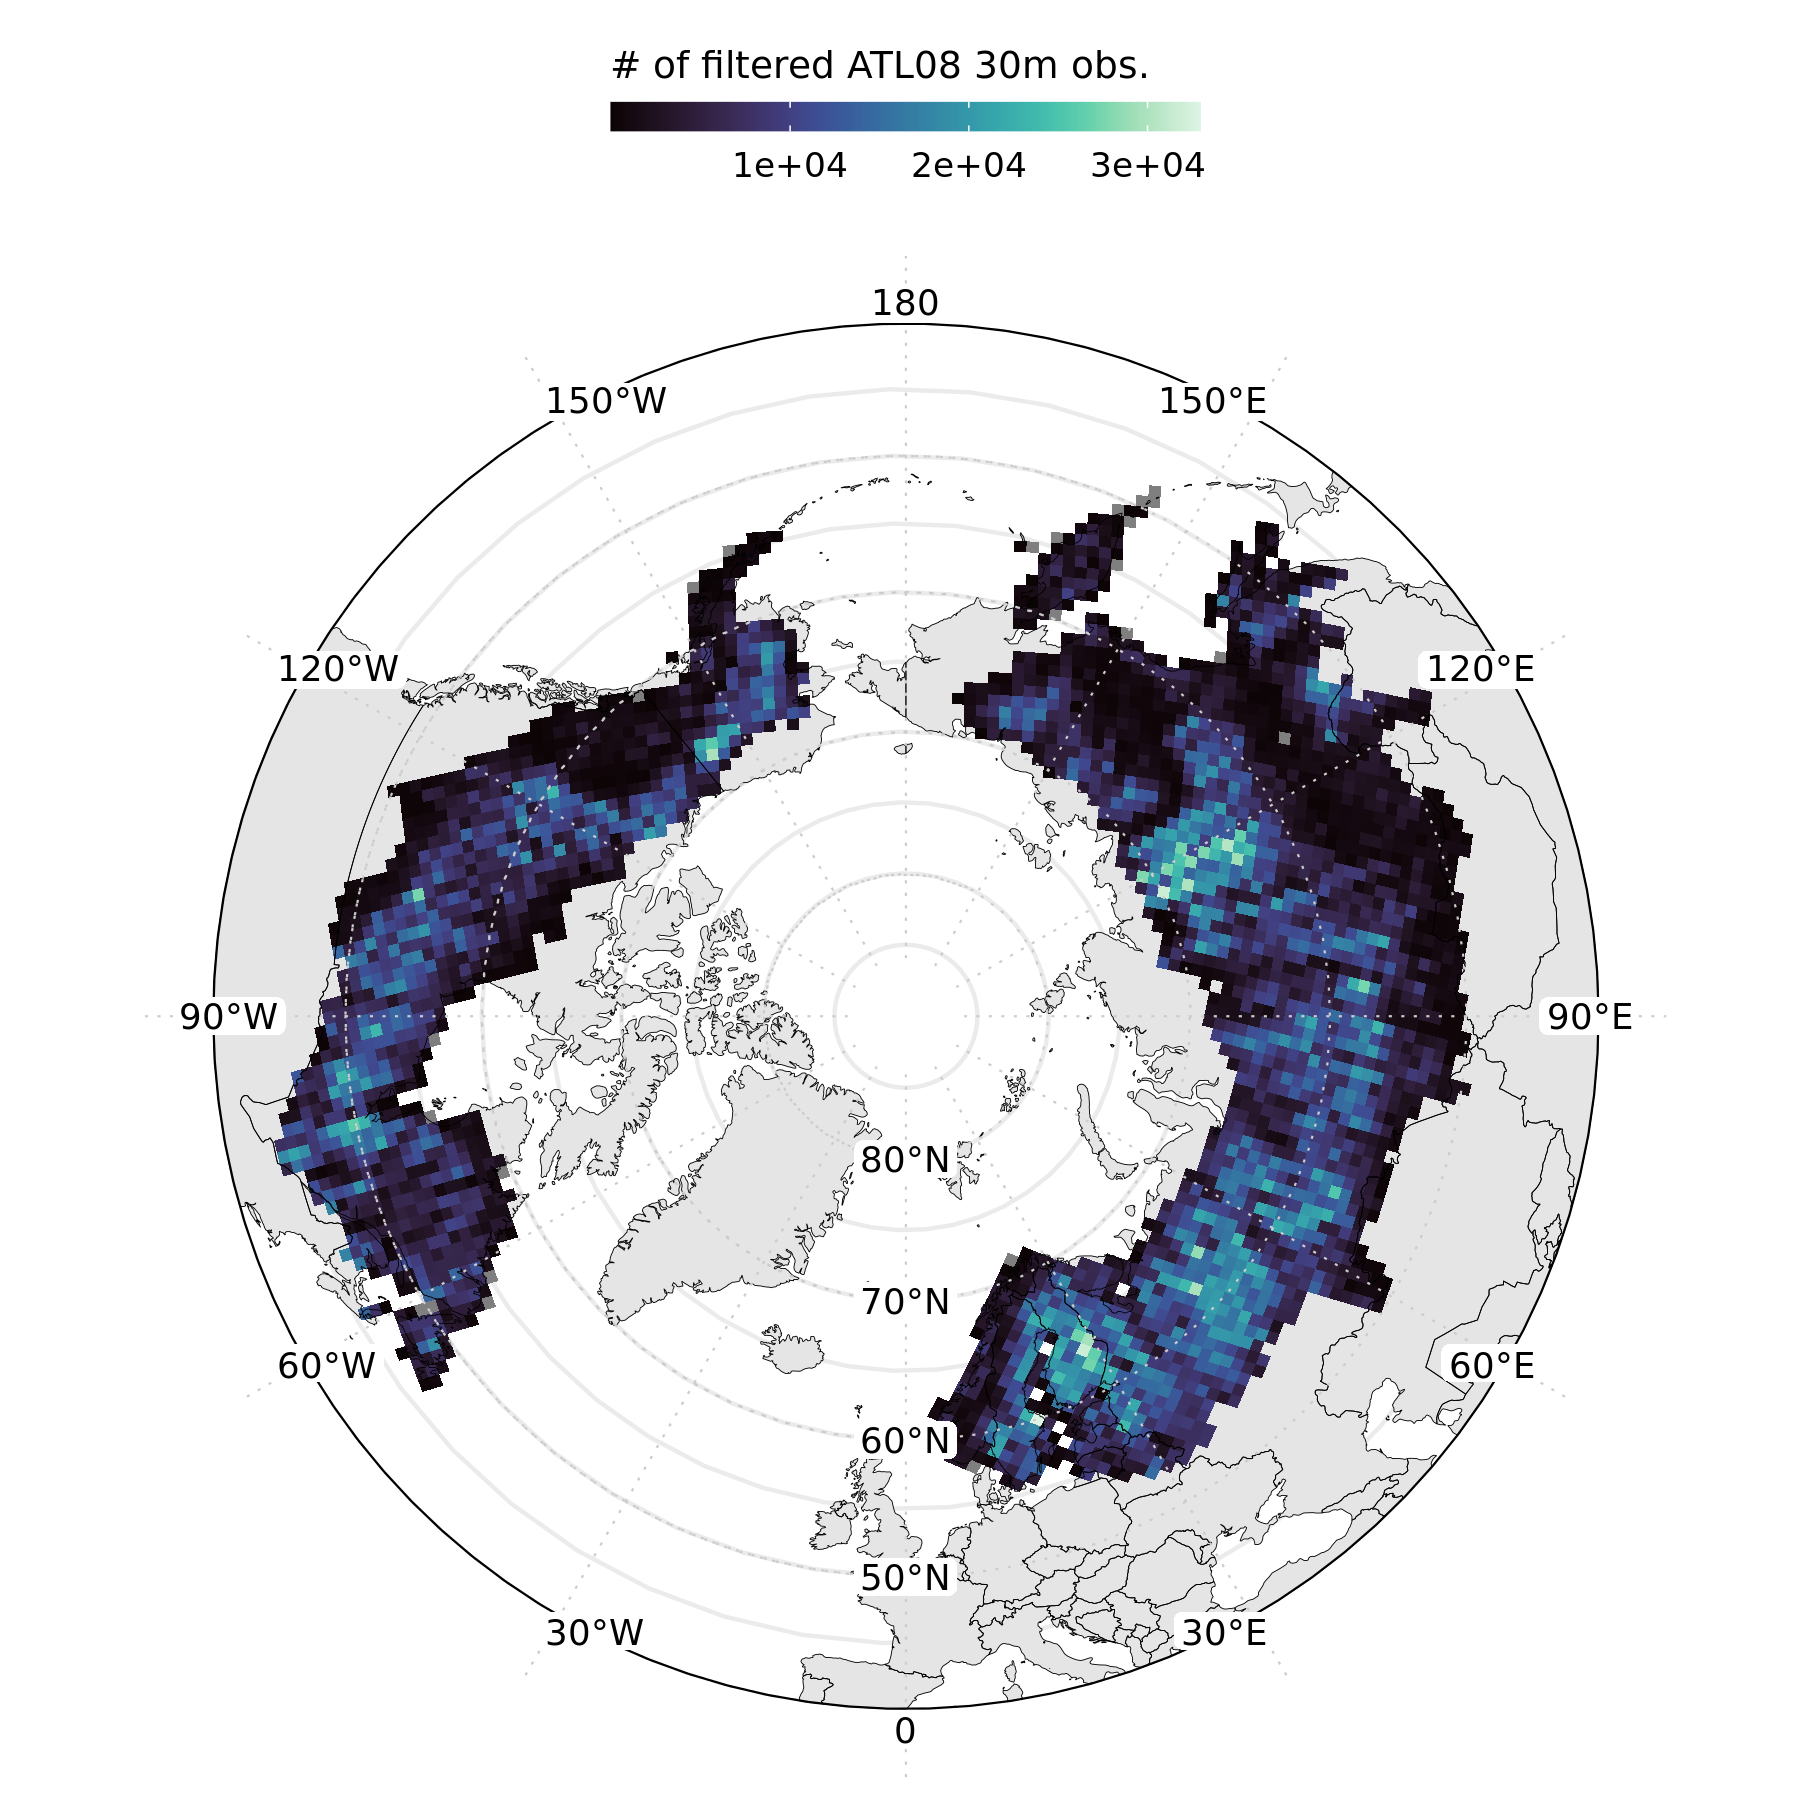

In [19]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)
# Show map of HLS compositing params

m_ATL08obs_tile = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     boreal_shp_fn = boreal_shp_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs_ATL08obs %>% dplyr::filter(tile_num %in% boreal_tile_num_list), 
                                                    aes(x = long, y = lat, group = group, fill=n_obs), size=0.1)
                                      )
                    ) + 
    theme(legend.text=element_text(size=rel(0.75))) +
    guides(fill=guide_colourbar(title="# of filtered ATL08 30m obs.", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))+
    scale_fill_viridis(option = 'mako', labels = scientific)

m_ATL08obs_tile

## Export figure: ATL08 obs count

In [21]:
DATA_NAME_STEM = "ATL08_obs_tile"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_ATL08obs_tile,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 6, height = 6)
}

/projects/my-public-bucket/boreal_ATL08_AGB/paper_figs/map_ATL08_obs_tile__20231122.png
/projects/my-public-bucket/boreal_ATL08_AGB/paper_figs/map_ATL08_obs_tile__20231122.pdf


In [22]:
nowdate = format(Sys.time(), '%Y%m%d')
nowdate

[1] "20231122"

In [ ]:
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global#bands
class_values = c( 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200)
class_names = c('No data',
                'Shrubs','Herbaceous','Cultivated/managed','Urban/built','Bare/sparse', 'Snow/ice','Permanent\nwater', 
                'Herbaceous\nwetland','Moss/lichen', 
                'Closed forest\nevergreen needle','Closed forest\nevergreen_broad','Closed forest\ndeciduous needle','Closed forest\ndeciduous broad',
                'Closed forest\nmixed', 'Closed forest\nunknown',
                'Open forest\nevergreen needle','Open forest\nevergreen_broad','Open forest\ndeciduous needle','Open forest\ndeciduous_broad',
                'Open forest\nmixed', 'Open forest\nunknown', 
                'Open sea')
class_colors = c('#282828',
                 '#FFBB22','#FFFF4C','#F096FF','#FA0000','#B4B4B4','#F0F0F0','#0032C8',
                 '#0096A0','#FAE6A0',
                 '#58481F','#009900','#70663E','#00CC00',
                 '#4E751F','#007800',
                 '#666000','#8DB400','#8D7400','#A0DC00',
                 '#929900','#648C00',
                 '#000080')
names(class_colors) = class_names
class_colors = class_colors[!(names(class_colors) %in% c('No data','Snow/ice','Open sea','Permanent\nwater','Cultivated/managed','Urban/built'))]
class_colors

NameError: name 'c' is not defined

In [24]:
#atl08 %>% st_write(atl08_flatgeobuf_fn, driver='FlatGeoBuf')
levels(factor(atl08$AGB_model_id))
levels(factor(atl08$REALM))

[1] "DBT_coarse_2.rds"   "ENT_coarse_1.rds"   "world_coarse_2.rds"

[1] "NA" "PA"

## Boxplot of AGBD by LC and REALM

## Summary stats

In [25]:
smry = atl08 %>% as.data.frame() %>%
    dplyr::summarize(
        mean_AGB = mean(AGB_mean_mg_ha),
        sd_AGB = sd(AGB_mean_mg_ha),
        median_AGB = median(AGB_mean_mg_ha),
        mad_AGB = mad(AGB_mean_mg_ha),
        n_obs = n()
    )
head(smry)

mean_AGB sd_AGB median_AGB mad_AGB  n_obs   
1 53.61767 56.342 32.47216   36.24914 19287550

In [26]:
smry_realm = atl08 %>% as.data.frame() %>%
    dplyr::group_by(REALM) %>%
    dplyr::summarize(
        mean_AGB = mean(AGB_mean_mg_ha),
        sd_AGB = sd(AGB_mean_mg_ha),
        median_AGB = median(AGB_mean_mg_ha),
        mad_AGB = mad(AGB_mean_mg_ha),
        n_obs = n()
    )
smry_realm

REALM mean_AGB sd_AGB   median_AGB mad_AGB  n_obs   
1 NA    26.35136 33.30633 14.77308   14.14323  5911305
2 PA    65.66735 60.11074 46.80060   48.62573 13376245

In [27]:
smry_realm_lc = atl08 %>% as.data.frame() %>%
    dplyr::group_by(REALM, seg_landcov) %>%
    dplyr::summarize(
        mean_AGB = mean(AGB_mean_mg_ha),
        sd_AGB = sd(AGB_mean_mg_ha),
        median_AGB = median(AGB_mean_mg_ha),
        mad_AGB = mad(AGB_mean_mg_ha),
        n_obs = n()
    )
smry_realm_lc

`summarise()` has grouped output by 'REALM'. You can override using the
`.groups` argument.


REALM seg_landcov                     mean_AGB   sd_AGB    median_AGB
1  NA    Bare/sparse                      60.679177 48.202058  48.812235
2  NA    Closed forest\ndeciduous broad    6.966720  6.751471   5.237775
3  NA    Closed forest\ndeciduous needle  13.817898 22.844320   8.182440
4  NA    Closed forest\nevergreen needle  34.293292 31.595969  25.687586
5  NA    Closed forest\nevergreen_broad   32.703139 36.057824  19.700958
6  NA    Closed forest\nmixed              5.671410  5.224418   3.919713
7  NA    Closed forest\nunknown            6.228501  5.467482   4.442675
8  NA    Herbaceous                       26.740753 20.776712  20.975210
9  NA    Herbaceous\nwetland              26.428240 19.334045  20.380312
10 NA    Open forest\nevergreen needle     3.491085  2.022736   2.975009
11 NA    Open forest\nevergreen_broad      4.233382  1.939723   3.991028
12 NA    Permanent\nwater                 17.595252 21.195516  12.663642
13 NA    Shrubs                           34.422347 34.153439  23.221544
14 NA    Snow/ice                         20.108869 28.582090  11.674306
15 NA    Urban/built                      64.163335 42.442042  60.111108
16 PA    Bare/sparse                     120.936497 73.241898 111.713085
17 PA    Closed forest\ndeciduous broad   11.891379 14.677340   6.728931
18 PA    Closed forest\ndeciduous needle  31.635367 41.963766  16.997980
19 PA    Closed forest\nevergreen needle  56.170829 45.809793  48.332859
20 PA    Closed forest\nevergreen_broad   56.239571 55.025747  38.678363
21 PA    Closed forest\nmixed              7.965239  6.941735   5.619480
22 PA    Closed forest\nunknown            7.159564  6.349253   4.867909
23 PA    Herbaceous                       49.729395 42.199934  36.732286
24 PA    Herbaceous\nwetland              35.221504 32.488847  26.256907
25 PA    Open forest\nevergreen needle     3.670460  2.011819   3.208885
26 PA    Open forest\nevergreen_broad      3.773625  1.699321   3.452266
27 PA    Permanent\nwater                 43.428392 41.835427  29.885744
28 PA    Shrubs                           82.998834 56.672334  70.836531
29 PA    Snow/ice                         30.684121 35.725287  20.769478
30 PA    Urban/built                      91.536737 56.755027  86.313103
   mad_AGB   n_obs  
1  37.939701  323624
2   3.618366  740765
3   6.232712 1021756
4  28.016486   14455
5  18.238615    8075
6   2.972549  307512
7   3.326025   25920
8  20.902620      18
9  15.993248      81
10  1.767604    1904
11  2.225038    5815
12  7.365998  345586
13 17.096390 2677261
14  9.060599  277400
15 44.353293  161133
16 77.031347 1535167
17  5.383007  175683
18 16.811541  921994
19 52.276578  123572
20 41.173318   39145
21  4.957058  469915
22  3.689964  243971
23 27.952809 2741119
24 23.808287   29371
25  1.889407     816
26  1.703913    2928
27 26.715203   68897
28 51.189432 3639834
29 16.461391 1731496
30 61.895198 1652337

In [28]:
write.csv(smry, file = paste0(tools::file_path_sans_ext(atl08_fn), '_smry.csv') )
write.csv(smry_realm, file = paste0(tools::file_path_sans_ext(atl08_fn), '_smry_realm.csv') )
write.csv(smry_realm_lc, file = paste0(tools::file_path_sans_ext(atl08_fn), '_smry_realm_lc.csv') )

In [29]:
plot_list = list(
    theme_bw(), 
    theme(axis.title = element_text(size=20), 
          axis.text = element_text(size=16), 
          strip.text = element_text(size=20),
          legend.text = element_text(size=18), 
          legend.title=element_text(size=20)
            )
    )
AGB_label_expression = expression(Aboveground~Biomass~Density~c.2020~(Mg%.%ha^{-1}))

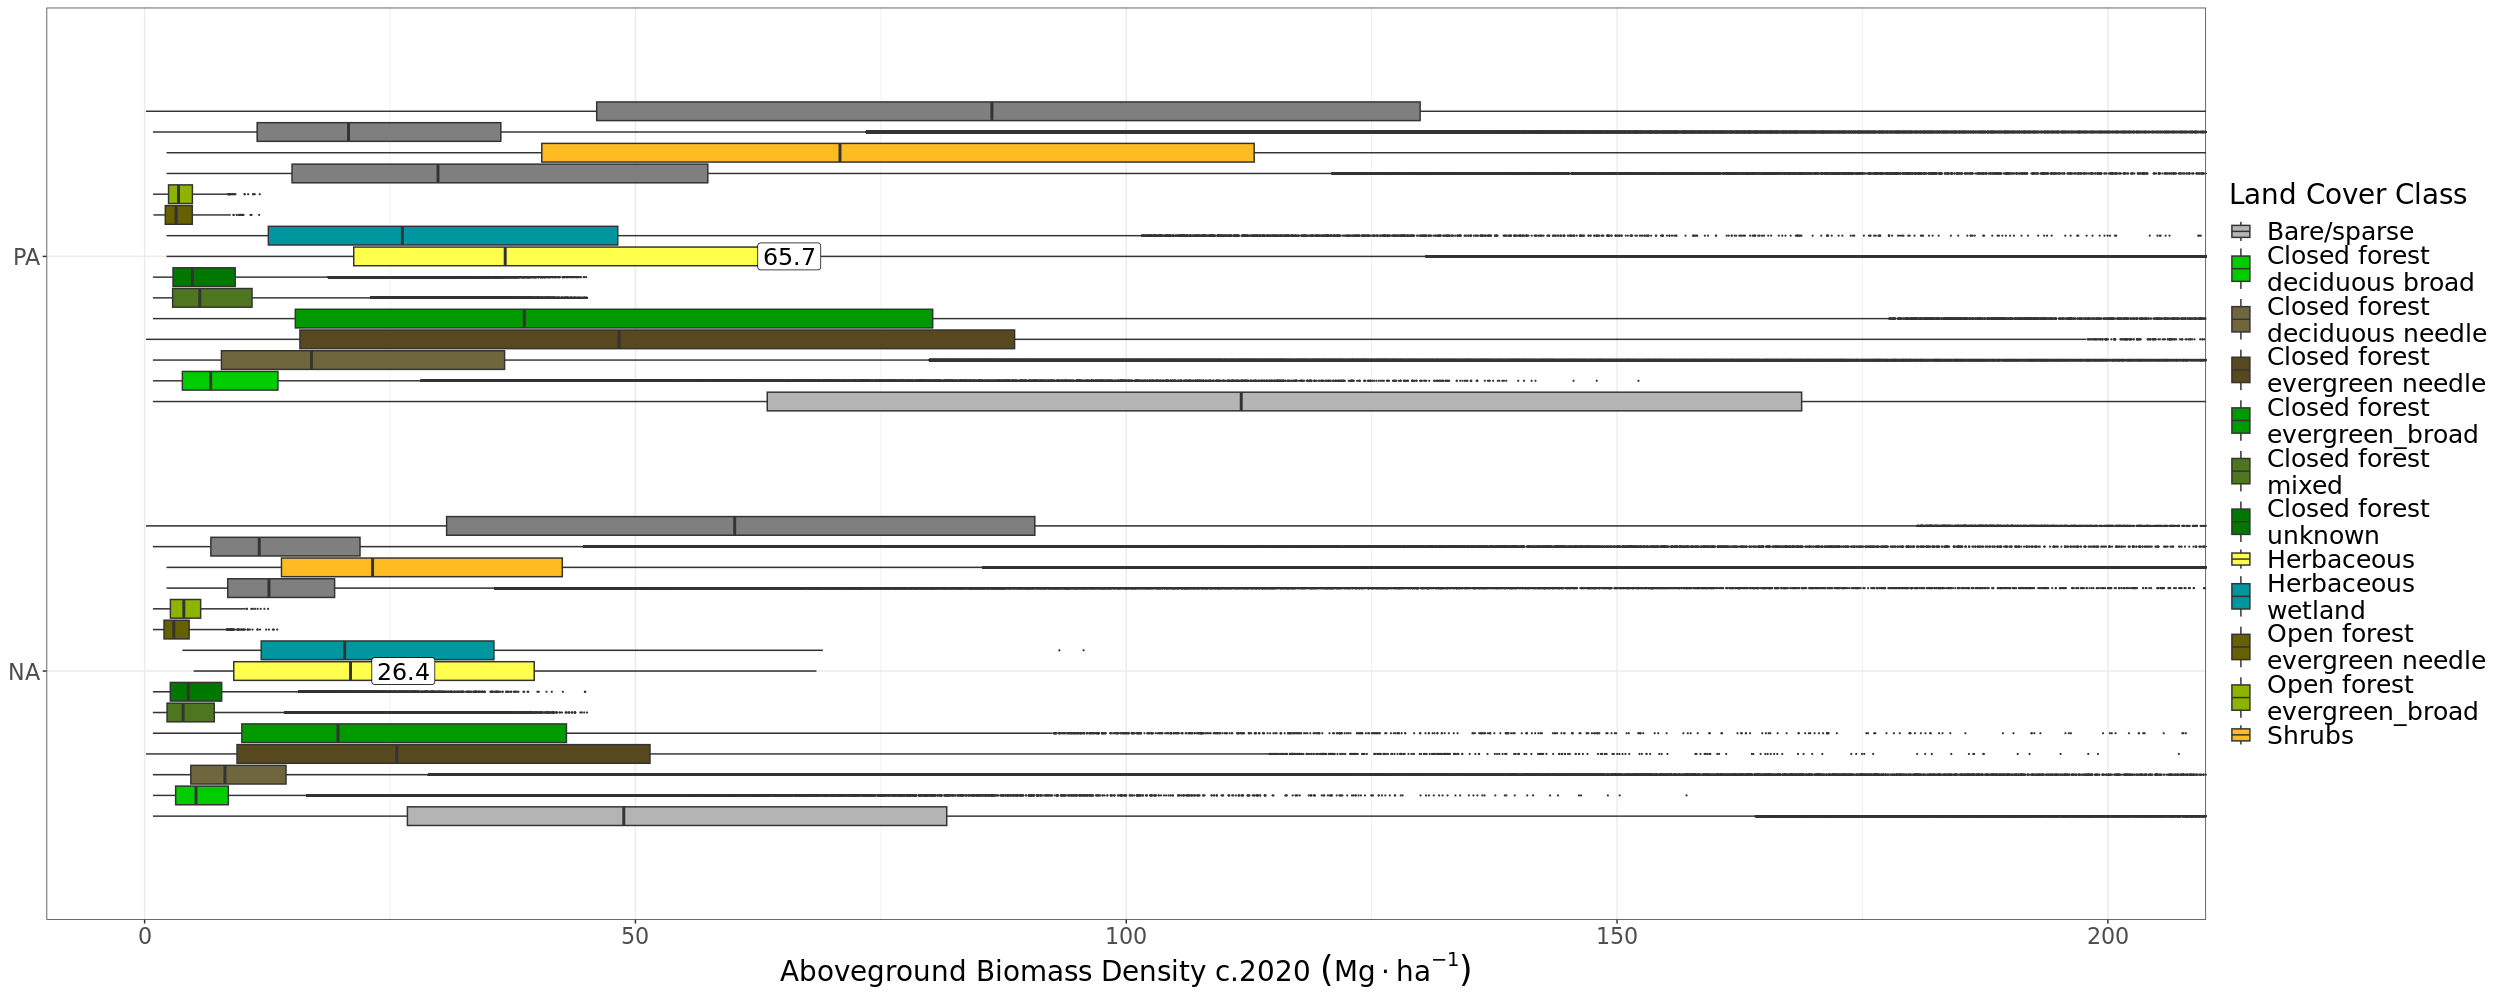

In [30]:
options(repr.plot.width = 25, repr.plot.height = 10, repr.plot.res = 100)

atl08 %>%
    ggplot() +  
    geom_boxplot(aes(x=REALM, y=AGB_mean_mg_ha, fill=seg_landcov), outlier.size = 0.1)+
    geom_label(data = smry_realm, aes(x = REALM, y = mean_AGB, label = round(mean_AGB,dig=1)), size = 6) +
    #scale_fill_gradientn(limits = c(0, 5), breaks = seq(0, 5, 0.5) , colours = c(viridis::plasma(10)) , oob=squish, name='Mg/ha') +
    #scale_fill_manual(values= colorRampPalette(brewer.pal(8, "Dark2"))(15), name='Boreal AGB\nmodel group') +
    #scale_fill_brewer(palette = 'Dark2', name='Realm', guide = "none") +
    scale_fill_manual(values = class_colors, name='Land Cover Class') +
    #scale_x_discrete(position = NULL) +
     plot_list +
    #facet_wrap(~REALM, ncol=2)+
    labs(x=NULL, y=AGB_label_expression) + 
    coord_flip(ylim=c(0,200))

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

box_agb_lc = atl08 %>%
    ggplot() +  
    geom_boxplot(aes(x=seg_landcov, y=AGB_mean_mg_ha, fill=seg_landcov), outlier.size = NULL)+
    geom_label(data = smry_realm_lc, aes(x = seg_landcov, y = mean_AGB, label = round(mean_AGB,dig=1)), size = 3) +
    #scale_fill_gradientn(limits = c(0, 5), breaks = seq(0, 5, 0.5) , colours = c(viridis::plasma(10)) , oob=squish, name='Mg/ha') +
    #scale_fill_manual(values= colorRampPalette(brewer.pal(8, "Dark2"))(15), name='Boreal AGB\nmodel group') +
    scale_fill_manual(values = class_colors, name='Land Cover Class', guide = "none") +
    #scale_x_discrete(position = NULL) +
     #plot_list +
    facet_wrap(~REALM, ncol=2)+
    labs(x=NULL, y=AGB_label_expression) + 
    coord_flip(ylim=c(0,200))

box_agb_lc

Warning message:
“The dot-dot notation (`..x..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(x)` instead.”


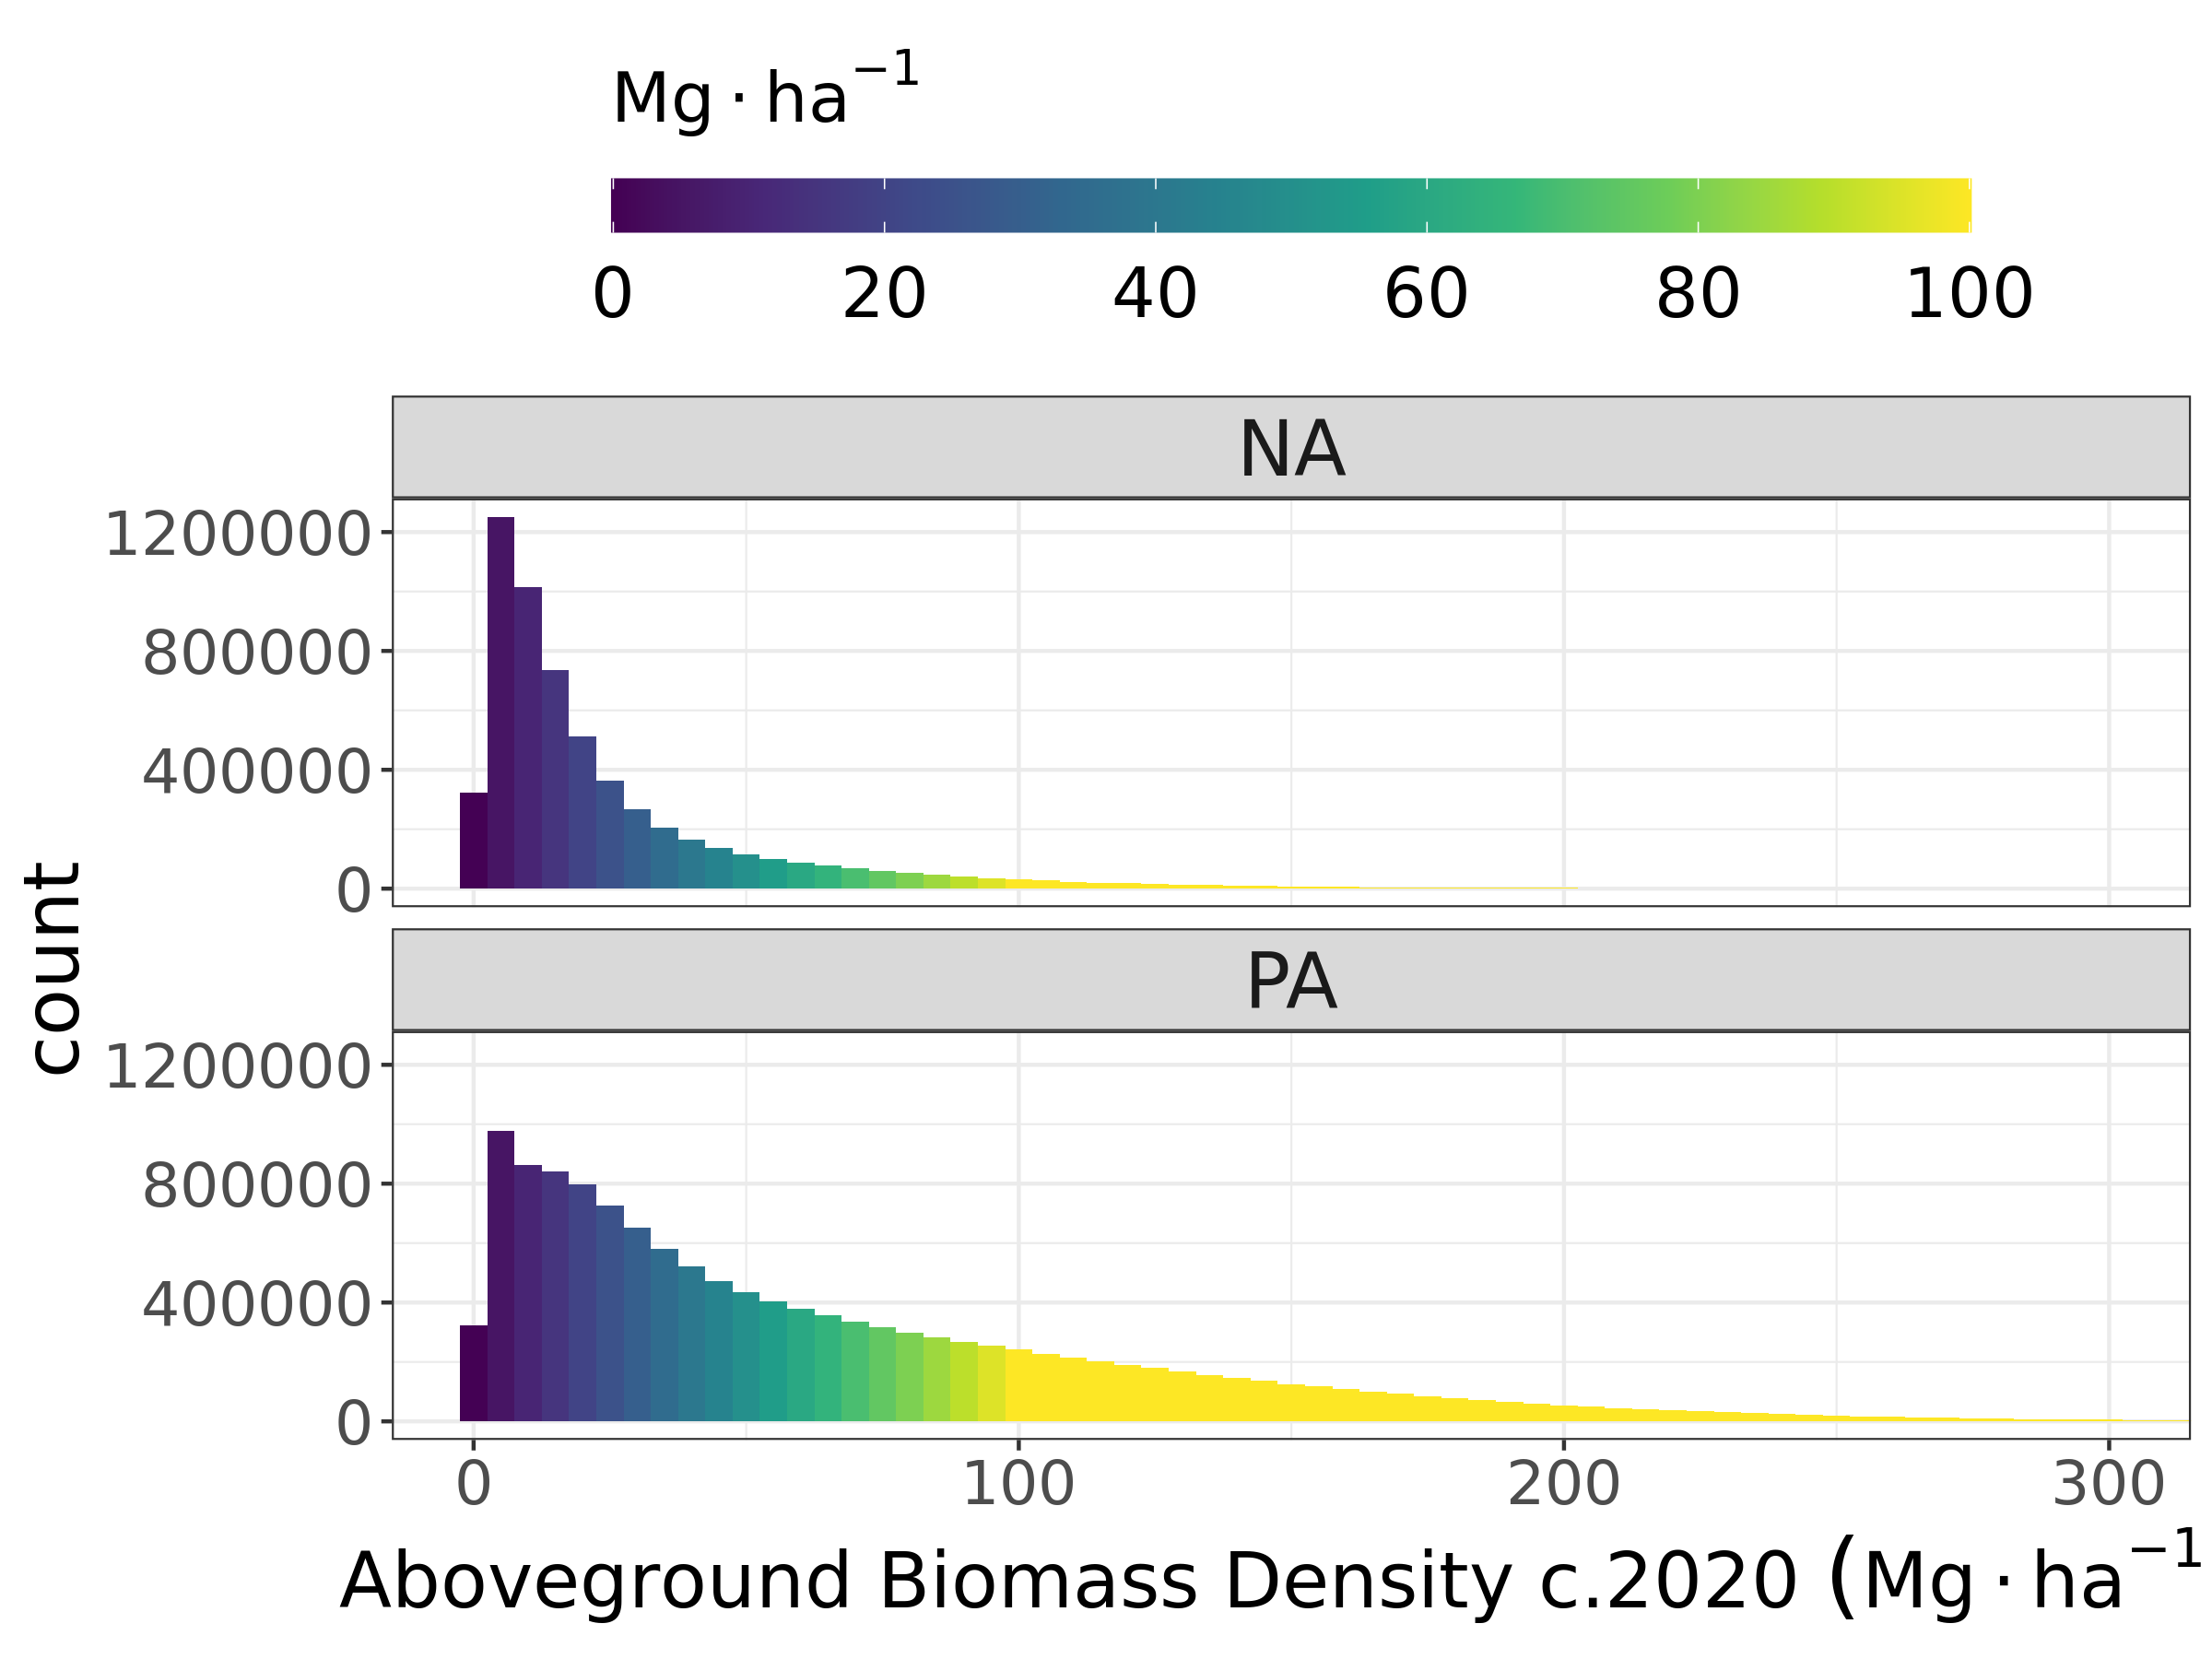

In [32]:
hist_agbmean = atl08 %>% 
    ggplot() + 
    geom_histogram(aes(x = AGB_mean_mg_ha, fill=..x..), binwidth=5 )+
    
 
    scale_fill_gradientn(limits = c(0, 100), labels = seq(0, 100, 20), breaks = seq(0, 100, 20), colours = c(viridis::viridis(10)) , oob=squish, name='Mg/ha') +
    #scale_fill_viridis() +
    coord_cartesian(xlim=c(0,300)) +
    #theme_bw()+
    plot_list +
    facet_wrap(~REALM, ncol=1) +
    labs(x=AGB_label_expression) +
   guides(fill=guide_colourbar(title=expression(Mg%.%ha^{-1}), title.position = "top", #label.position = "bottom", 
                                keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))+
#guides(guide = guide_legend(direction = "horizontal", nrow=1, label.position = "bottom", title.position = "top") ) +
    theme(legend.position="top",
          legend.title = element_text(size=18),
          #       legend.direction  = 'vertical',
          legend.key.width  = unit(2.5, "cm"),
          legend.key.height = unit(.5, "cm")  )

hist_agbmean

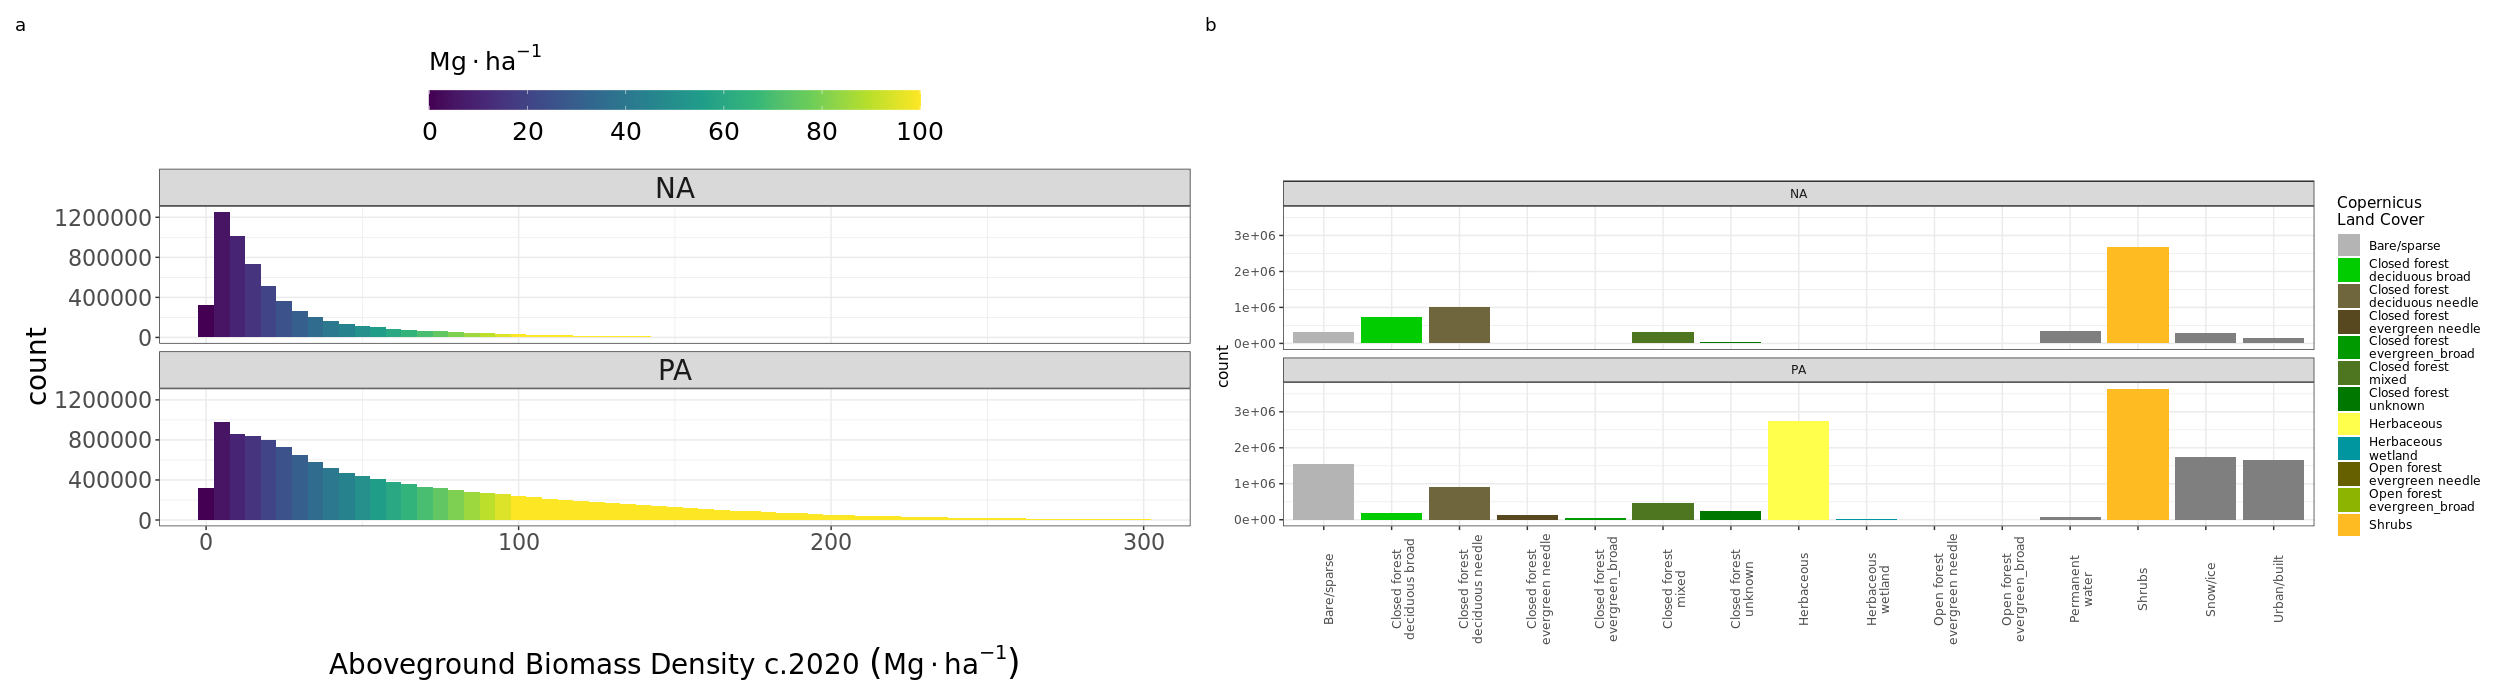

In [33]:
options(repr.plot.width = 25, repr.plot.height = 7, repr.plot.res = 100)

# hist_agbse = atl08 %>% 
#     ggplot() +  
#     geom_bar(aes(y=as.numeric(AGB_se_mg_ha), x=factor(AGB_model_id), fill=factor(AGB_model_id)) , stat="identity")+
#     #scale_fill_gradientn(limits = c(0, 5), breaks = seq(0, 5, 0.5) , colours = c(viridis::plasma(10)) , oob=squish, name='Mg/ha') +
#     #scale_fill_viridis() +
#     coord_cartesian(xlim=c(0,5)) +
#     theme_bw() +
#     theme(axis.text.x = element_text(angle=45))+
#     facet_wrap(~REALM, ncol=1)
#     #facet_wrap(.~AGB_model_id, ncol=3, scales='free_x') 

hist_landcov = atl08 %>% 
    ggplot() +  
    geom_bar(aes(x=factor(seg_landcov), fill=factor(seg_landcov)))+
    #scale_fill_gradientn(limits = c(0, 5), breaks = seq(0, 5, 0.5) , colours = c(viridis::plasma(10)) , oob=squish, name='Mg/ha') +
    #scale_fill_manual(values= colorRampPalette(brewer.pal(8, "Dark2"))(15), name='Boreal AGB\nmodel group') +
    scale_fill_manual(values= class_colors, name='Copernicus\nLand Cover') +
    #coord_cartesian(xlim=c(0,5)) +
    theme_bw() + theme(axis.text.x = element_text(angle=90)) +
    facet_wrap(.~AGB_model_id, ncol=3, scales='free_x') +
    facet_wrap(~REALM, ncol=1)+
    labs(x=NULL)
                         
layout = "
AB
"

hist_agbmean + hist_landcov +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))


In [34]:
min_lat = 45
if(FALSE){
    atl08 = st_intersection(st_as_sf(
                                    sample_frac(
                                                atl08 %>% dplyr::select(tile_num, lon, lat, RH_98, AGB) %>% dplyr::filter(lat > min_lat),
                                                1
                                                ),
                                    coords = c('lon', 'lat') , 
                                    remove = FALSE,
                                    crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"), 
                            boreal # intersect ATL08 with boreal extent
                            #boreal_tiles_clip # intersect ATL08 with boreal tiles extent
                                    ) %>%
                            as.data.frame() %>%
                            dplyr::select(tile_num,lon,lat,RH_98,AGB,REALM)
    #atl08_sf = as(cbind(atl08_sf, st_coordinates(atl08_sf)), 'Spatial') 
    }

In [35]:
dim(atl08)

[1] 19287550       19

## Plot filtered ATL08 30m obs across boreal tiles domain
set up the plotting variables

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


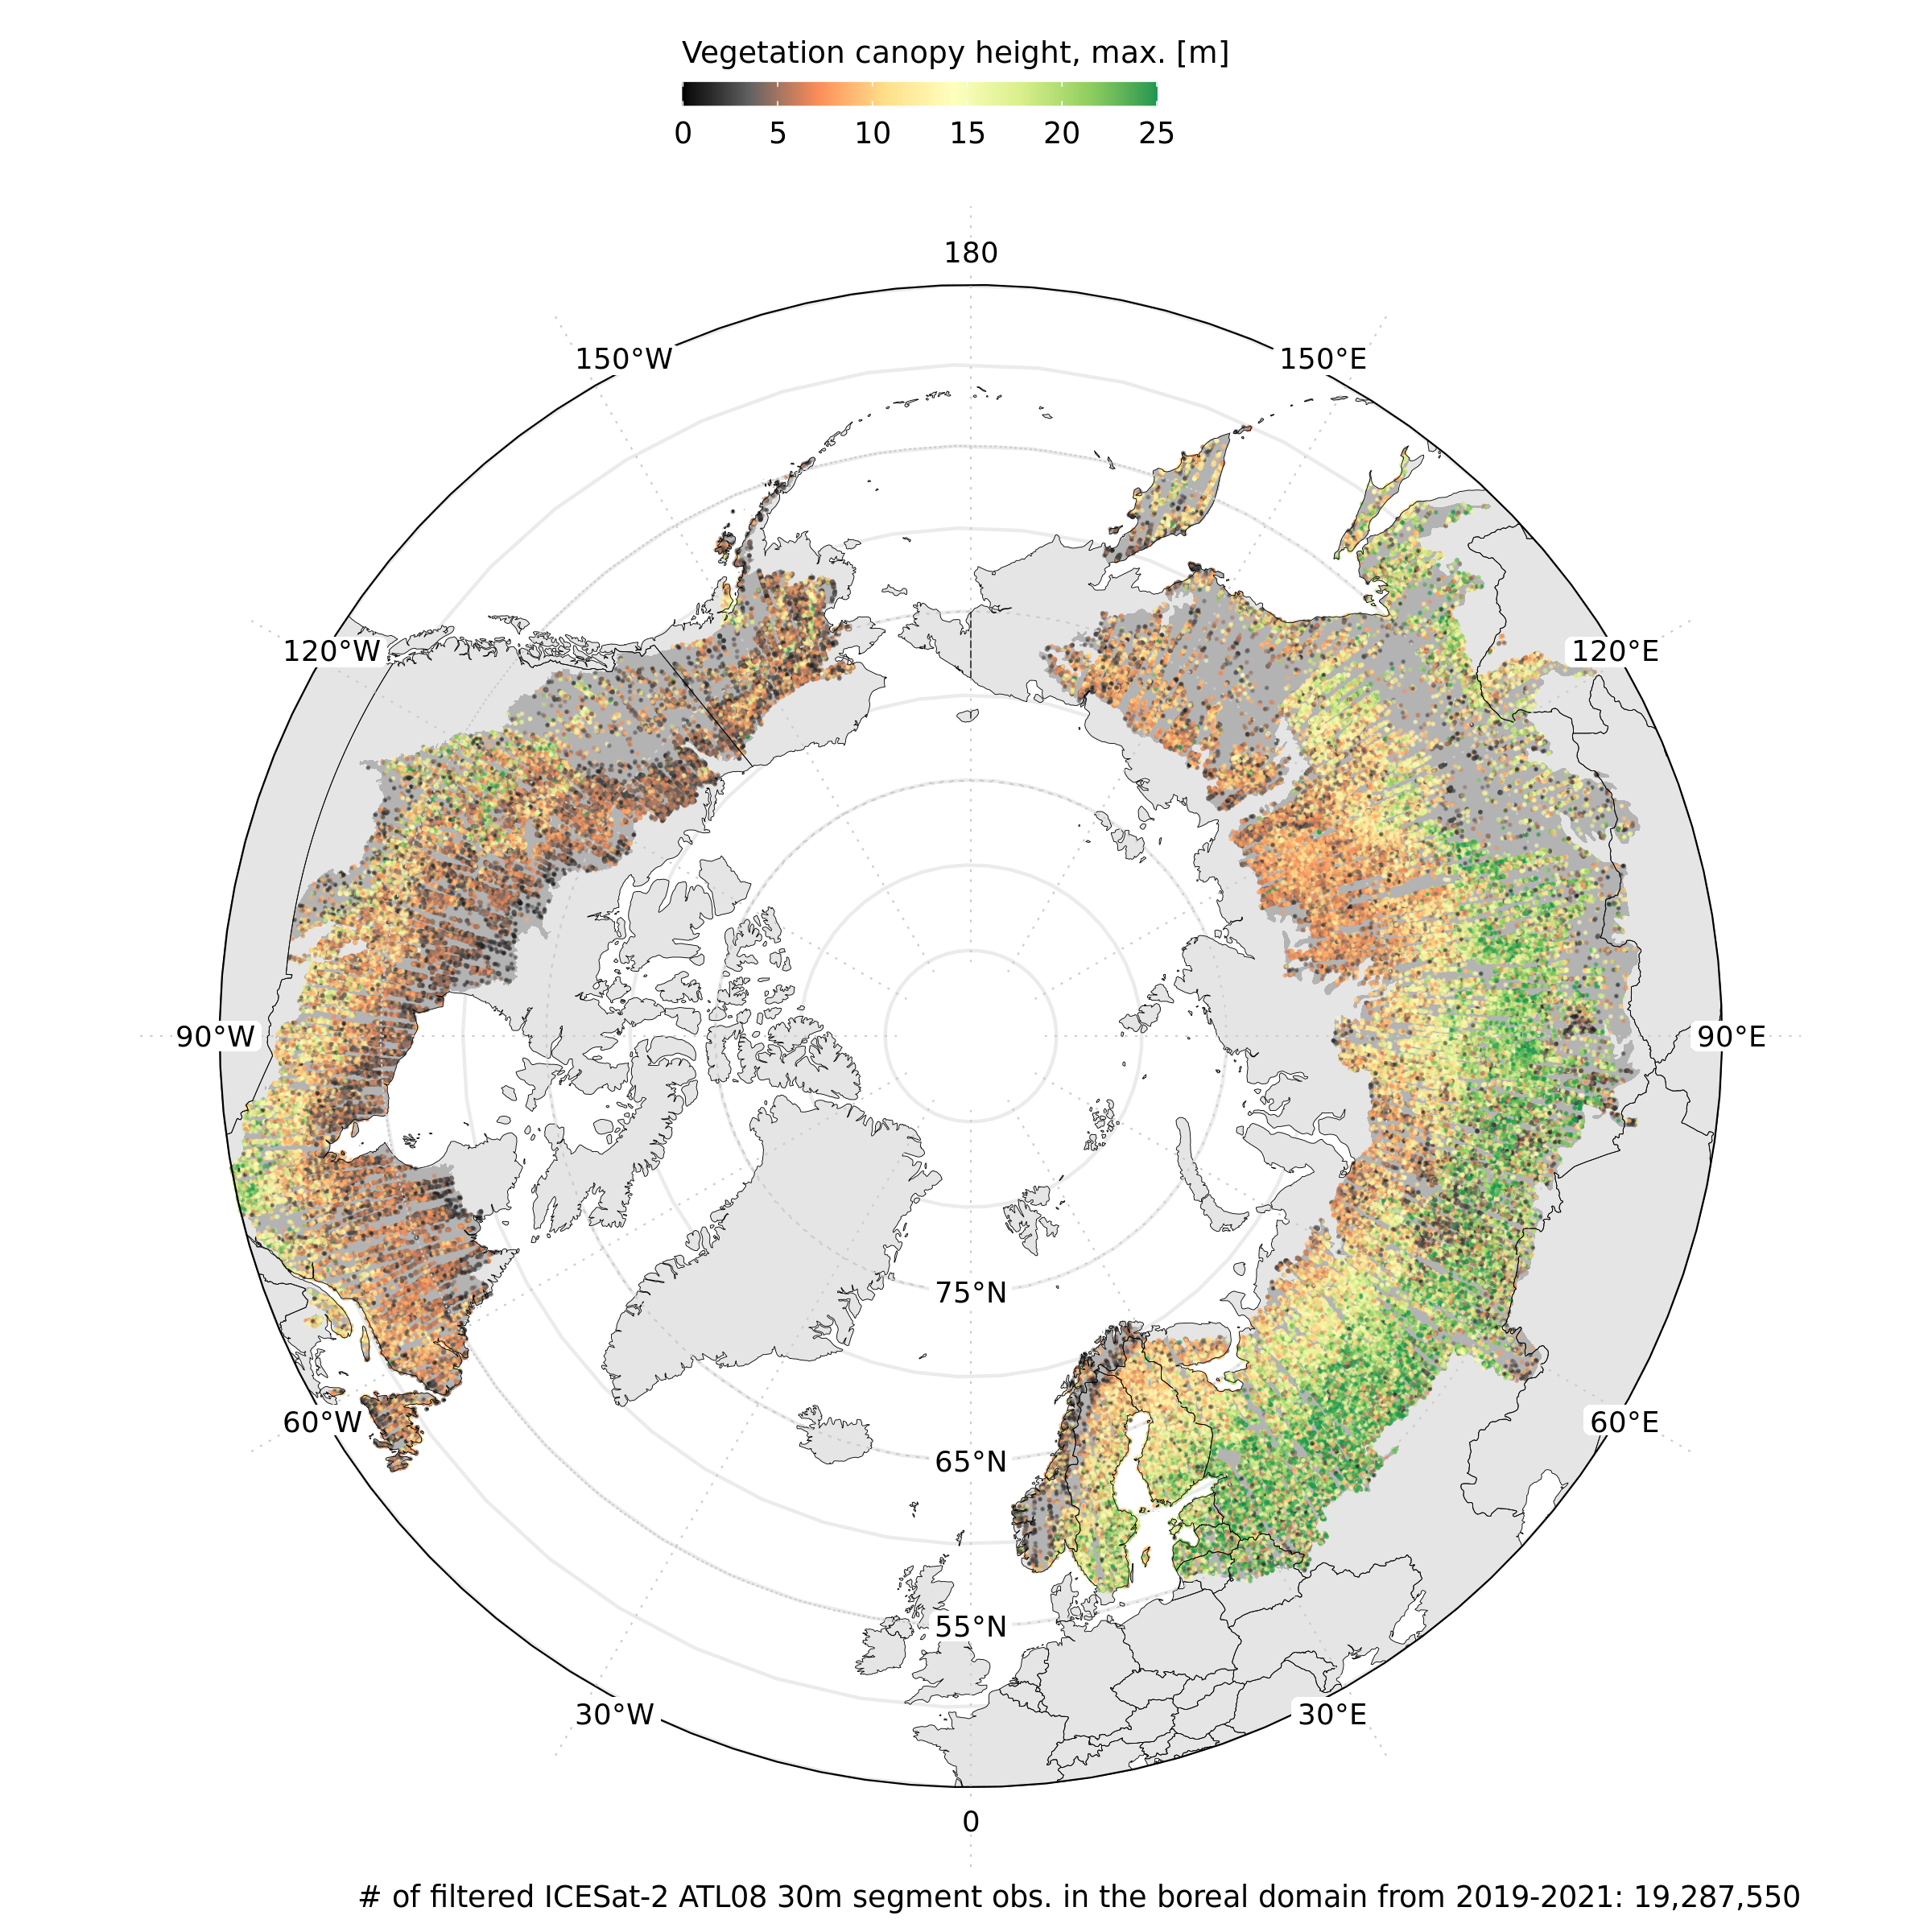

In [36]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)

pal_ht = c('black','#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850')
min_lat = 45
year_atl08 = '2019-2021'

# if(TRUE){
#     df = atl08_sf %>% 
#         as.data.frame() %>%
#         #dplyr::filter(Y > min_lat, night_flg==1)
#         dplyr::filter(Y > min_lat) # We use solar elev < 5
# }else{
#     df = atl08 %>%
#         dplyr::filter(lat > min_lat) 
# }

NUM_ATL08_OBS = prettyNum(dim(atl08)[1],big.mark=",",scientific=FALSE)

# # FRACTION
# df = sample_frac(df, 0.01)


#NUM_ATL08_NIGHT_OBS = prettyNum(dim(atl08 %>% as.data.frame() %>% filter(night_flg==1))[1],big.mark=",",scientific=FALSE)

theme_and_labs = list(
    theme_classic(),
    theme(plot.subtitle=element_text(size=8, hjust=0.5, face="italic", color="black")),
    labs(
        #title="Vegetation canopy heights",
        #subtitle = paste0("Filtered sample of ICESat-2 ATL08 30m observations of RH98 in the boreal forest"," for ",year_atl08),
         #caption = paste0("# obs: ", NUM_ATL08_OBS, "\n# obs (night): ", NUM_ATL08_NIGHT_OBS)
         caption = paste0("# of filtered ICESat-2 ATL08 30m segment obs. in the boreal domain from ", year_atl08,": ", NUM_ATL08_OBS)
    )    
)
scale_color_h_can = scale_colour_gradientn( breaks=c(0,5,10,15, 20, 25), limits = c(0,25), colours=pal_ht, oob=squish)


var_ht = 'RH_98'

map_height_layer_list = list(
    geom_point(data = sample_frac(atl08, 0.01) %>% filter(lat > min_lat), 
               aes_string(x = "lon", y = "lat", colour=var_ht), alpha=0.5, size = 0.00001),
    scale_color_h_can,
    theme_and_labs,
    guides(color=guide_colourbar(title="Vegetation canopy height, max. [m]", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))
  )
m_ATL08_obs = DO_MAP_BOREAL_SP(MAP_EXTENT=extent(-180,180,min_lat,90), boreal_shp_fn = boreal_shp_fn, LAYER_LIST = map_height_layer_list)
m_ATL08_obs

## Export figure: ATL08 obs

In [37]:
DATA_NAME_STEM = "ATL08_obs_filt_boreal_clip"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", var_ht, EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_ATL08_obs,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 6, height = 6)
}

/projects/my-public-bucket/boreal_ATL08_AGB/paper_figs/map_ATL08_obs_filt_boreal_clip_RH_98_20231122.png
/projects/my-public-bucket/boreal_ATL08_AGB/paper_figs/map_ATL08_obs_filt_boreal_clip_RH_98_20231122.pdf


In [38]:
#writeOGR(atl08, path(out_dir, paste0(DATA_NAME_STEM,"_", EXPORT_TIME_STR), layer=DATA_NAME_STEM, driver="GeoJSON")
#st_write(atl08, path(out_dir, paste0(DATA_NAME_STEM,"_", EXPORT_TIME_STR, ".gpkg"), DATA_NAME_STEM)

## Plot ATL08 AGB obs

OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


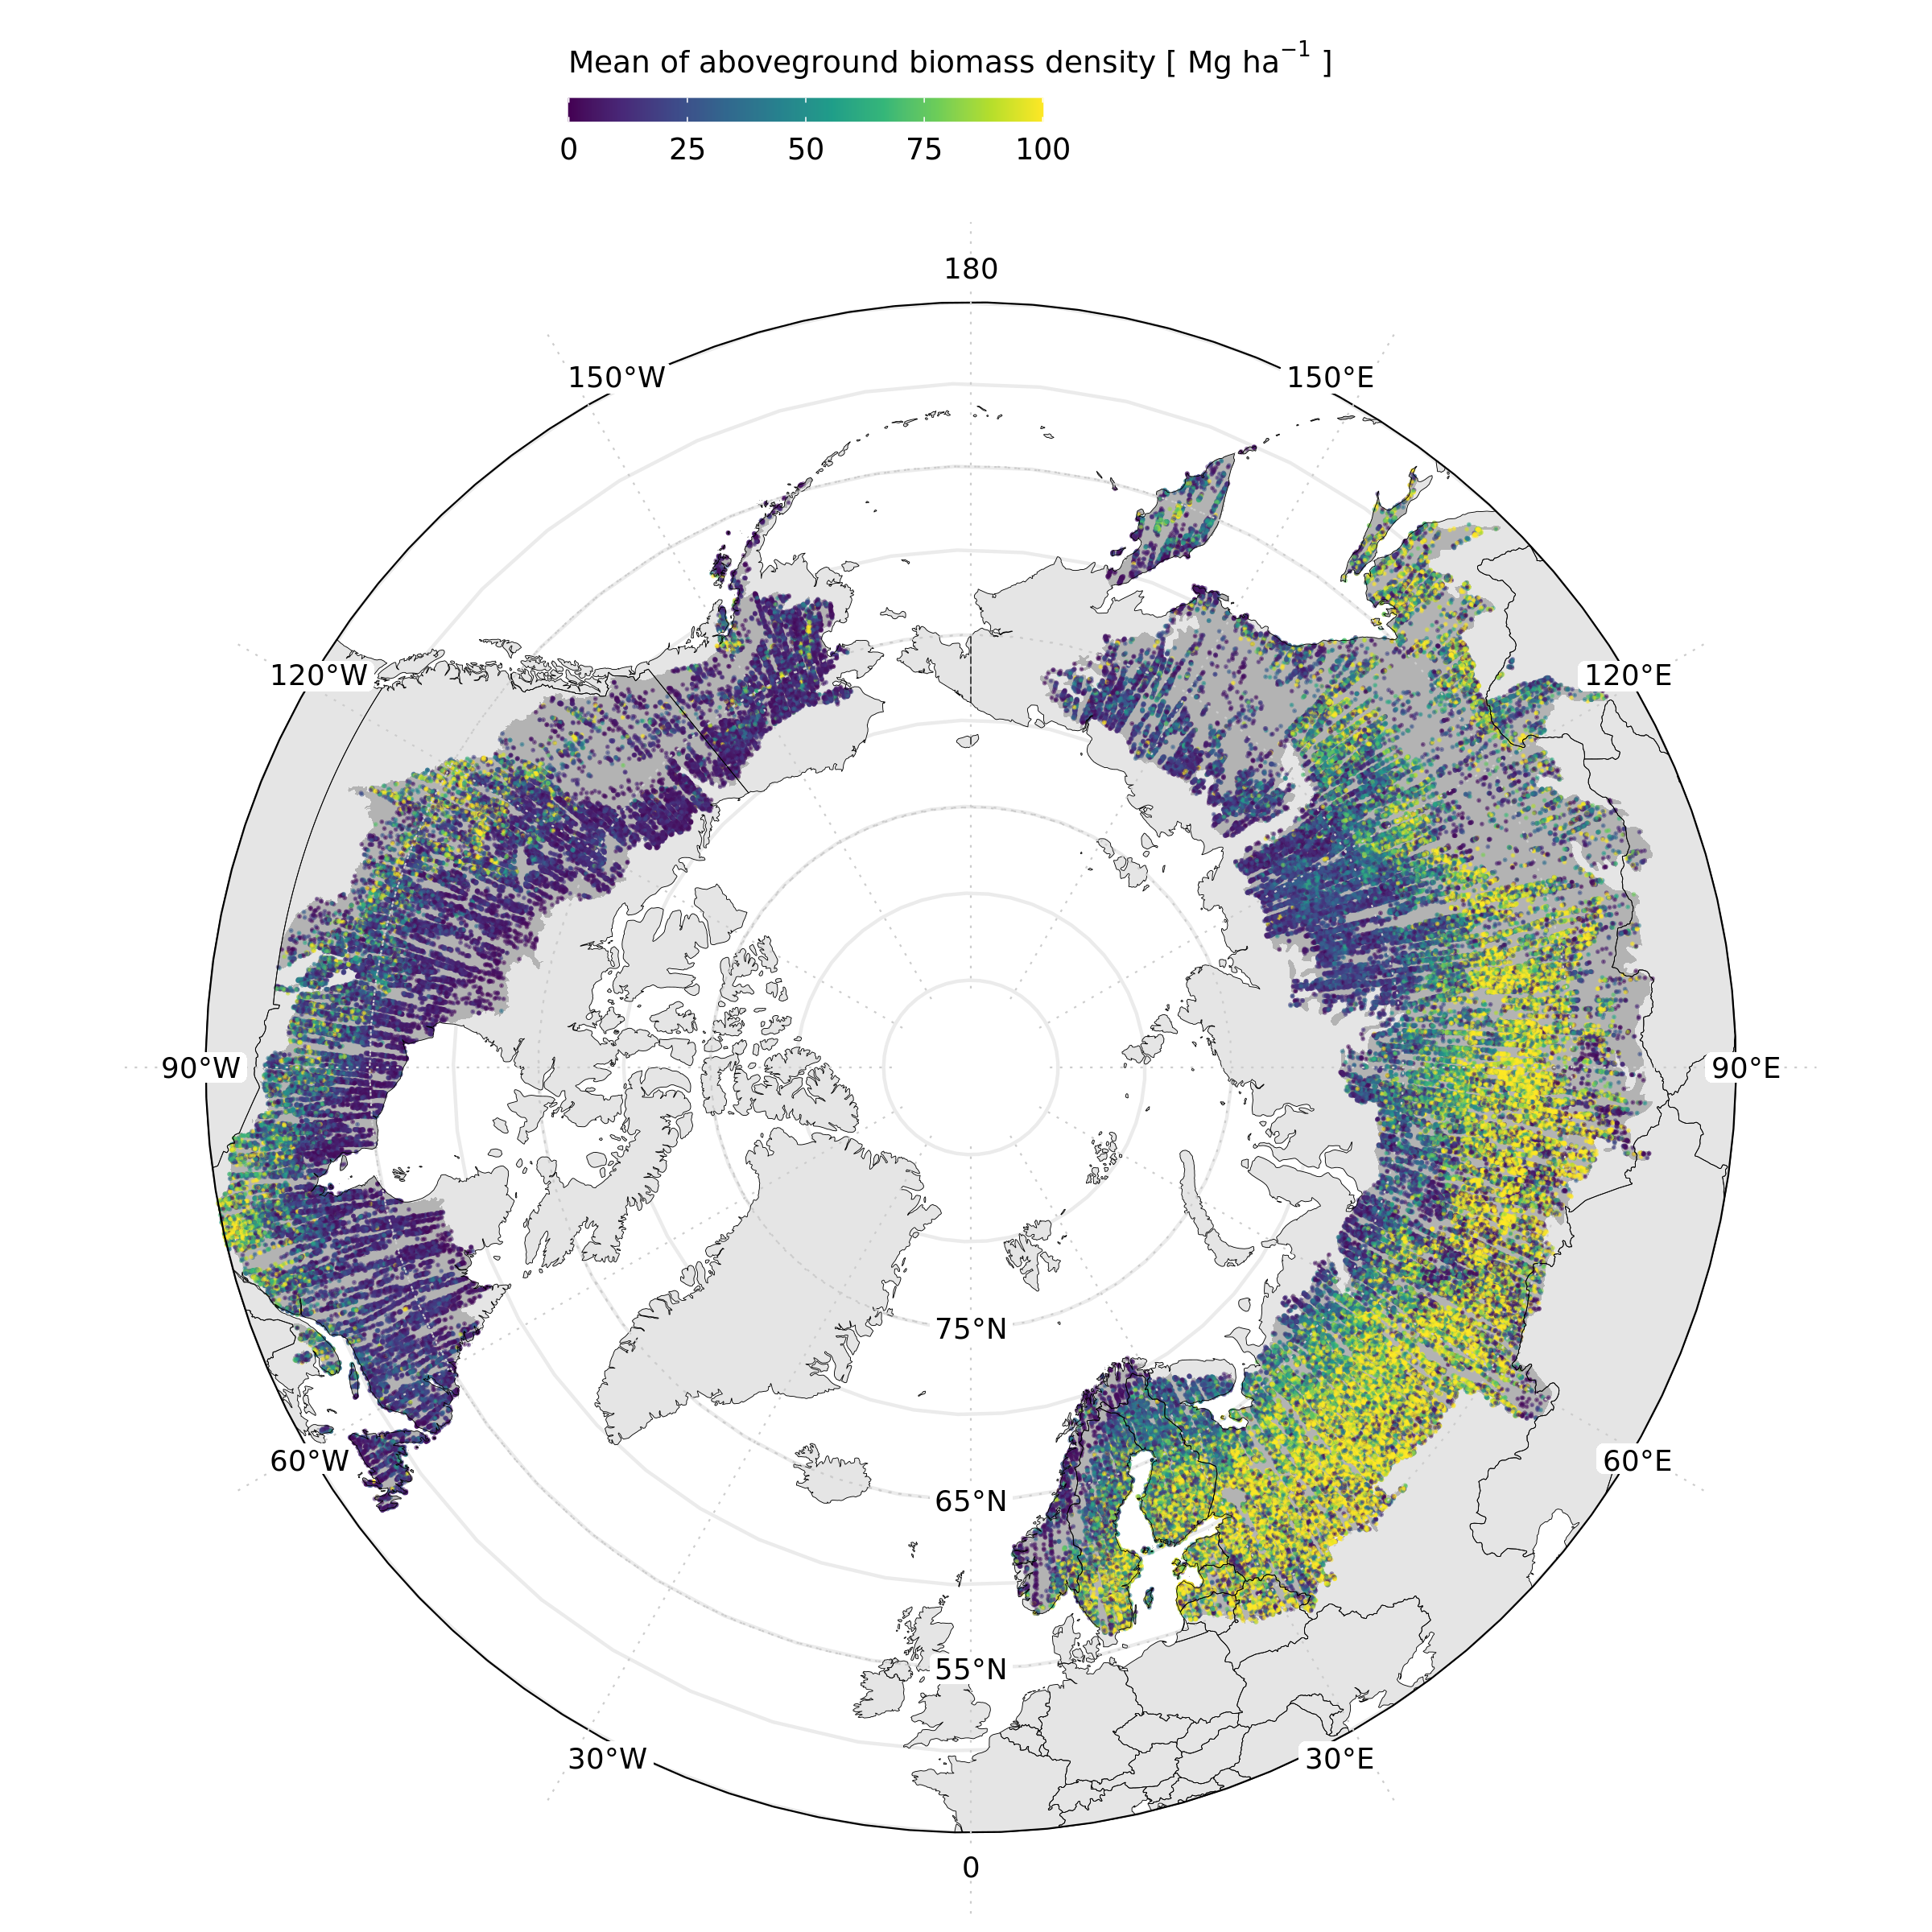

In [39]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)


MAX_AGB = 100
min_lat = 45
year_atl08 = '2019-2021'


NUM_ATL08_OBS = prettyNum(dim(atl08)[1],big.mark=",",scientific=FALSE)



#NUM_ATL08_NIGHT_OBS = prettyNum(dim(atl08 %>% as.data.frame() %>% filter(night_flg==1))[1],big.mark=",",scientific=FALSE)

theme_and_labs = list(
    theme_classic(),
    theme(plot.subtitle=element_text(size=8, hjust=0.5, face="italic", color="black")),
    labs(
        #title="Vegetation canopy heights",
        #subtitle = paste0("Filtered sample of ICESat-2 ATL08 30m observations of RH98 in the boreal forest"," for ",year_atl08),
         #caption = paste0("# obs: ", NUM_ATL08_OBS, "\n# obs (night): ", NUM_ATL08_NIGHT_OBS)
         #caption = paste0("# of ICESat-2 ATL08 30m segment AGB training obs. from ", year_atl08,": ", NUM_ATL08_TRAINOBS)
    )    
)


var_ht = "AGB_mean_mg_ha"

map_AGB_layer_list = list(
    geom_point(data = sample_frac(atl08, 0.01) %>% filter(lat > min_lat), aes_string(x = "lon", y = "lat", colour=var_ht), alpha=0.5, size = 0.00001),
    scale_color_gradientn(limits = c(0,MAX_AGB), breaks = seq(0,MAX_AGB,25), colours = viridis(10), , oob=squish ),
    theme_and_labs,
    guides(color=guide_colourbar(title=expression("Mean of aboveground biomass density ["~Mg~ha^{-1}~"]"), title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))
  )
m_AGBtrain_obs = DO_MAP_BOREAL_SP(MAP_EXTENT=extent(-180,180,min_lat,90), boreal_shp_fn = boreal_shp_fn, LAYER_LIST = map_AGB_layer_list)
m_AGBtrain_obs

## Export figure: ATL08 AGB obs

In [40]:
DATA_NAME_STEM = "ATL08AGB_obs_filt_boreal_clip"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", var_ht, EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_AGBtrain_obs,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 6, height = 6)
}

/projects/my-public-bucket/boreal_ATL08_AGB/paper_figs/map_ATL08AGB_obs_filt_boreal_clip_AGB_mean_mg_ha_20231122.png
/projects/my-public-bucket/boreal_ATL08_AGB/paper_figs/map_ATL08AGB_obs_filt_boreal_clip_AGB_mean_mg_ha_20231122.pdf


## Plot ATL08 land cover classes

In [41]:
models_list

ERROR: Error in eval(expr, envir, enclos): object 'models_list' not found


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)

MAX_AGB = 100
min_lat = 45
year_atl08 = '2019-2021'

NUM_ATL08_OBS = prettyNum(dim(atl08)[1],big.mark=",",scientific=FALSE)

theme_and_labs = list(
    theme_classic(),
    theme(plot.subtitle=element_text(size=8, hjust=0.5, face="italic", color="black"))    
)

var_ht = "seg_landcov"

map_AGB_layer_list = list(
    geom_point(data = sample_frac(atl08, 0.01) %>% 
               filter(lat > min_lat)# %>% 
               #filter((seg_landcov != 'No data') | (seg_landcov != 'Open sea') | (seg_landcov != 'Snow/ice')) %>% droplevels()
               , aes_string(x = "lon", y = "lat", colour=var_ht), alpha=0.5, size = 0.00001),
    scale_color_manual(values=class_colors, name='Copernicus\nLand Cover',drop = TRUE),    
    theme_and_labs,
    theme(legend.text=element_text(size=0.25)),
    guides(color=guide_legend(override.aes = list(size = 3,alpha=1),
                              ncol=9,
                              title=expression("Land Cover Class"), 
                              title.position = "top", 
                              label.position = "bottom", 
                              keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))
  )
m_LC_obs = DO_MAP_BOREAL_SP(MAP_EXTENT=extent(-180,180,min_lat,90), boreal_shp_fn = boreal_shp_fn, LAYER_LIST = map_AGB_layer_list) + 
    theme(legend.text=element_text(size=6)) 
m_LC_obs

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 12, repr.plot.res = 300)

layout = "
AA
AA
BB
"
m_LC_obs + box_agb_lc +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a') 

## Plot AGB model ID

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)

min_lat = 45
year_atl08 = '2019-2021'


NUM_ATL08_OBS = prettyNum(dim(atl08)[1],big.mark=",",scientific=FALSE)

theme_and_labs = list(
    theme_classic(),
    theme(plot.subtitle=element_text(size=8, hjust=0.5, face="italic", color="black"))    
)


var_ht = "AGB_model_id"

map_AGB_layer_list = list(
    geom_point(data = sample_frac(atl08, 0.01) %>% filter(lat > min_lat), aes_string(x = "lon", y = "lat", colour=var_ht), alpha=0.5, size = 0.00001),
    scale_color_viridis_d( name='Copernicus\nLand Cover', labels = c('DBT', 'ENT', 'Pan-boreal')),    
    theme_and_labs,
    guides(color=guide_legend(override.aes = list(size = 5), title=expression("ICESat-2 land cover strata AGBD model"), title.position = "top", label.position = "bottom", keywidth = unit(0.5, "cm"), keyheight = unit(0.25, "cm")))
  )
m_AGBmodelid = DO_MAP_BOREAL_SP(MAP_EXTENT=extent(-180,180,min_lat,90), boreal_shp_fn = boreal_shp_fn, LAYER_LIST = map_AGB_layer_list)
m_AGBmodelid

## Export figure: AGB model ID map

In [ ]:
DATA_NAME_STEM = "ATL08_obs_filt_boreal_clip"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", var_ht, EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_AGBmodelid,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 6, height = 6)
}

# Read the tables with the obs of ICESat-2 ATL08 AGB used for tile model training  
these training data tables will be delivered to the DAAC as companions to the biomass COGS  
each of these tile specific tables include obs outside the tile bounds - to accomodate the 'global' AGB model component applied to each tile-specific model

In [ ]:
AGB_tindex_master$s3_path_train = with(AGB_tindex_master, stringi::stri_replace_all_fixed(s3_path, '.tif', "_train_data.csv"))
head(AGB_tindex_master)

In [ ]:
smry_tile_train = atl08_agb_train %>% 
    dplyr::mutate(tile_num = as.numeric(tile_num)) %>%
    dplyr::group_by(tile_num) %>%
    dplyr::summarize(n_obs = n())
write.csv(smry_tile_train, file = paste0(OUTDIR,'/tables/smry_atl08_agb_train_tiles.csv'))
head(smry_tile_train)

In [ ]:
boreal_tiles_gcs_ATL08obs_AGBtrain = boreal_tiles_gcs %>% 
    dplyr::mutate(tile_num = as.numeric(tile_num)) %>% 
    dplyr::left_join(smry_tile_train, by = c('tile_num' = 'tile_num'))
head(boreal_tiles_gcs_ATL08obs_AGBtrain)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)
# Show map of HLS compositing params

m_ATL08obs_AGBtrain_tile = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     boreal_shp_fn = boreal_shp_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs_ATL08obs_AGBtrain %>% dplyr::filter(tile_num %in% boreal_tile_num_list), 
                                                    aes(x = long, y = lat, group = group, fill=n_obs), size=0.1)
                                      )
                    ) + 
    theme(legend.text=element_text(size=rel(0.75))) +
    guides(fill=guide_colourbar(title="# of filtered ATL08 30m obs. for AGB model training", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))+
    scale_fill_viridis(option = 'turbo', labels = scientific)

m_ATL08obs_AGBtrain_tile